In [2]:
#THIS BLOCK TURNS player_profiles.csv AND report_metrics.csv THEN CLEANS IT INTO cleaned_data.csv
#AFTER THIS cleaned_data.csv WILL BE READY TO USE IN THE NEXT BLOCK

import pandas as pd

profiles_path = "catapult_profiles.csv" #season averages (over many periods)
metrics_path = "catapult_report.csv" #period averages

profiles = pd.read_csv(profiles_path)
metrics = pd.read_csv(metrics_path)

id_cols = ["player_id", "player_name"]

profiles_extra = [c for c in profiles.columns if c not in id_cols]
metrics_extra  = [c for c in metrics.columns  if c not in id_cols]

profiles_renamed = profiles.rename(
    columns={c: (c + "_season" if c != "num_periods" else "num_periods_season")
             for c in profiles_extra}
)

metrics_renamed = metrics.rename(
    columns={c: c + "_period" for c in metrics_extra}
)

merged = pd.merge(profiles_renamed, metrics_renamed, on=id_cols, how="outer")

merged.to_csv("catapult_data.csv", index=False)


IDENTIFYING PLAYERS OVER THE Fatigue Index THRESHOLD (1.00x):
THERE ARE 3 PLAYERS ABOVE THE THRESHOLD:
 - Player 15: 1.26×
 - Player 13: 1.06×
 - Player 33: 1.03×



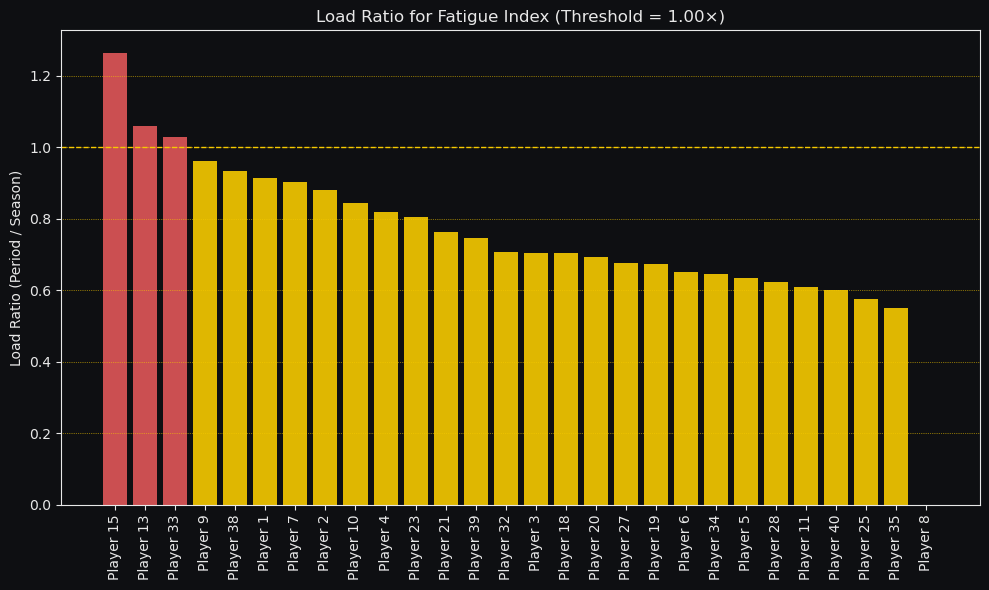

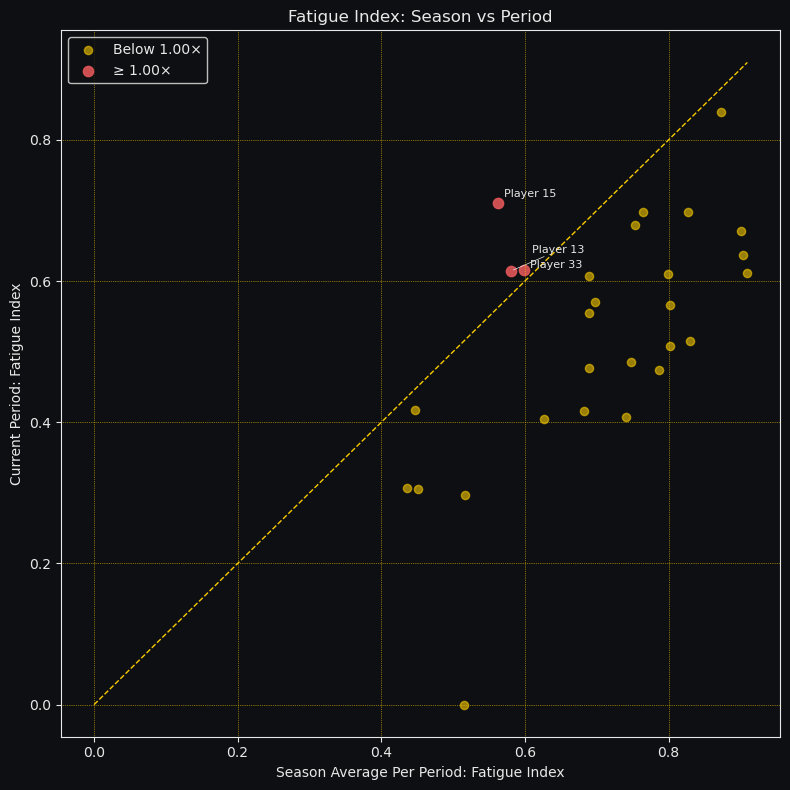


DISPLAYING LOAD PROFILES FOR PLAYERS ABOVE THE Fatigue Index THRESHOLD (1.00×):
 - Player 15
 - Player 13
 - Player 33



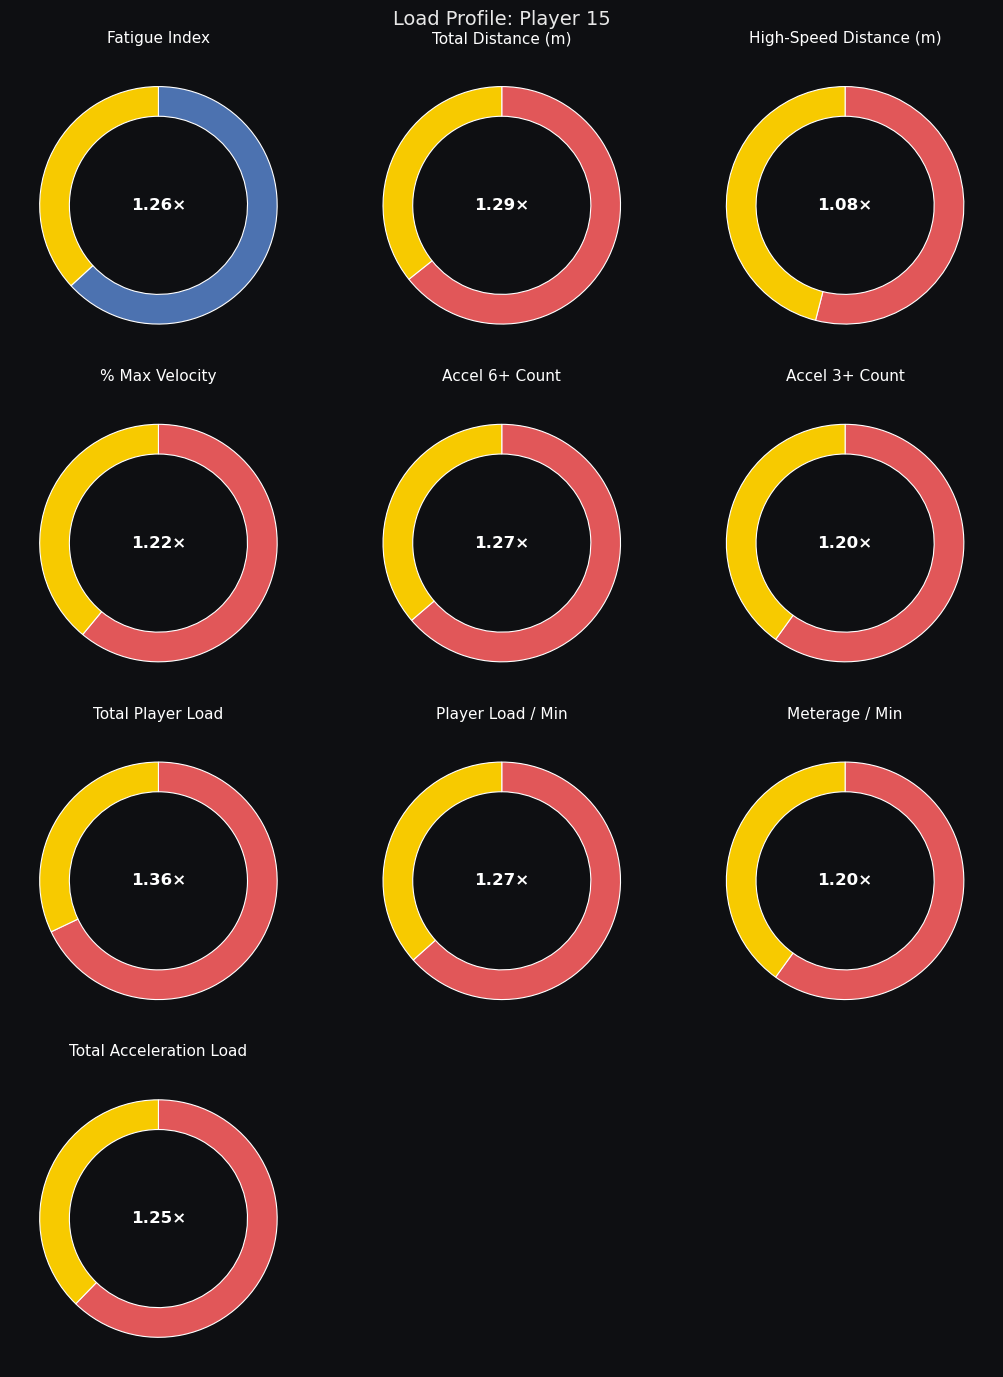

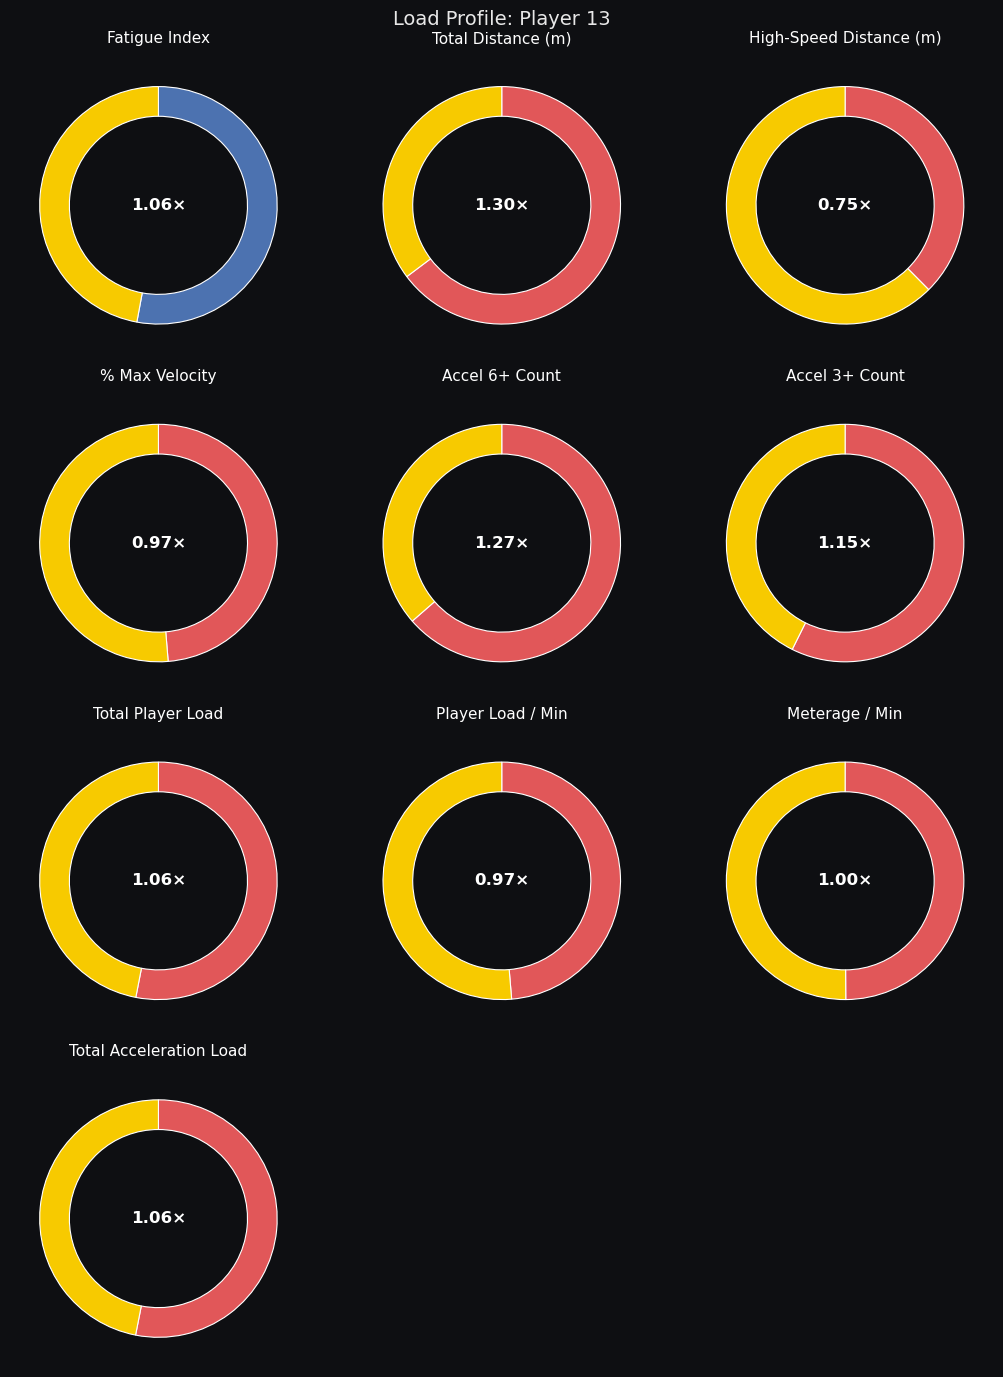

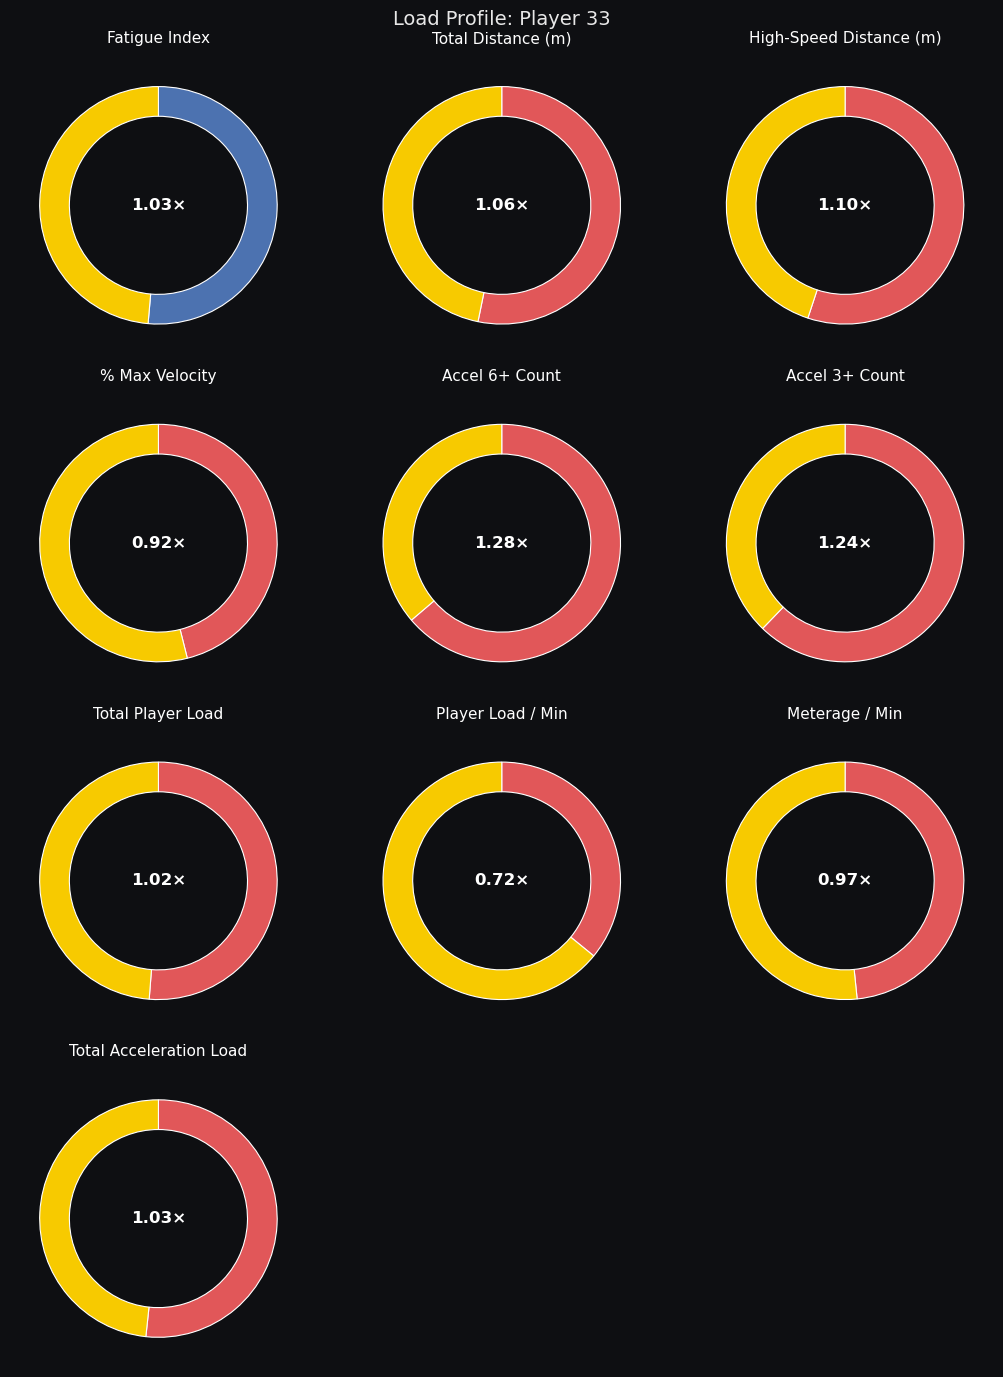

In [3]:
#THIS BLOCK TURNS cleaned_data.csv INTO VIZ AND INSIGHTS
#HIGHLIGHTS PLAYERS OVER A GIVEN METRIC AND THRESHOLD, DISPLAYS INDIVIDUAL STATS OF THOSE PLAYERS
#YOU CAN CHANGE THESE VARIABLES NEAR THE BOTTOM OF THIS BLOCK

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

try:
    from adjustText import adjust_text
    _USE_ADJUST_TEXT = True
except Exception:
    _USE_ADJUST_TEXT = False

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#f7ca00"
HIGHLIGHT_COLOR = "#e15759"
FATIGUE_COLOR = "#4c72b0"

plt.rcParams["axes.edgecolor"] = FG_COLOR
plt.rcParams["axes.labelcolor"] = FG_COLOR
plt.rcParams["xtick.color"] = FG_COLOR
plt.rcParams["ytick.color"] = FG_COLOR
plt.rcParams["text.color"] = FG_COLOR
plt.rcParams["figure.facecolor"] = BG_COLOR

METRICS = [
    "total_distance",
    "high_speed_distance",
    "percentage_max_velocity",
    "red_zone",
    "gen2_acceleration_band6plus_total_effort_count",
    "gen2_acceleration_band3plus_total_effort_count",

    "total_player_load",
    "player_load_per_minute",
    "meterage_per_minute",
    "total_acceleration_load",
    # "avg_trimp",
    # "percentage_max_heart_rate",
]

FATIGUE_COMPONENTS = [
    "total_distance",
    "high_speed_distance",
    "percentage_max_velocity",
    "gen2_acceleration_band6plus_total_effort_count",
    "gen2_acceleration_band3plus_total_effort_count",

    "total_player_load",
    "player_load_per_minute",
    "meterage_per_minute",
    "total_acceleration_load",
    # "avg_trimp",
    # "percentage_max_heart_rate",
]

PROFILE_METRICS = ["fatigue_index"] + FATIGUE_COMPONENTS

DISPLAY_NAMES = {
    "total_distance": "Total Distance (m)",
    "high_speed_distance": "High-Speed Distance (m)",
    "percentage_max_velocity": "% Max Velocity",
    "red_zone": "Red Zone Time",
    "gen2_acceleration_band6plus_total_effort_count": "Accel 6+ Count",
    "gen2_acceleration_band3plus_total_effort_count": "Accel 3+ Count",
    "fatigue_index": "Fatigue Index",

    "total_player_load": "Total Player Load",
    "player_load_per_minute": "Player Load / Min",
    "meterage_per_minute": "Meterage / Min",
    "total_acceleration_load": "Total Acceleration Load",
    # "avg_trimp": "Average Trimp",
    # "percentage_max_heart_rate": "% Max Heart Rate",
}

def _pretty_name(metric_base: str) -> str:
    return DISPLAY_NAMES.get(metric_base, metric_base.replace("_", " ").title())

def add_fatigue_index(df, components=None, weights=None):

    if components is None:
        components = FATIGUE_COMPONENTS

    if weights is None:
        weights = {m: 1.0 for m in components}
    else:
        weights = {m: float(weights.get(m, 1.0)) for m in components}

    n = len(df)
    if n == 0:
        return df

    season_score = np.zeros(n, dtype=float)
    period_score = np.zeros(n, dtype=float)
    season_denom = np.zeros(n, dtype=float)
    period_denom = np.zeros(n, dtype=float)

    for m in components:
        season_col = f"{m}_season"
        period_col = f"{m}_period"

        if season_col not in df.columns or period_col not in df.columns:
            continue

        season_vals = df[season_col].to_numpy(dtype=float)
        period_vals = df[period_col].to_numpy(dtype=float)

        all_vals = np.concatenate([
            season_vals[~np.isnan(season_vals)],
            period_vals[~np.isnan(period_vals)],
        ])

        if all_vals.size == 0:
            continue

        vmin = np.nanmin(all_vals)
        vmax = np.nanmax(all_vals)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or abs(vmax - vmin) < 1e-9:
            continue

        s_scaled = (season_vals - vmin) / (vmax - vmin)
        p_scaled = (period_vals - vmin) / (vmax - vmin)

        w = weights[m]

        mask_s = ~np.isnan(s_scaled)
        mask_p = ~np.isnan(p_scaled)

        season_score[mask_s] += w * s_scaled[mask_s]
        season_denom[mask_s] += w

        period_score[mask_p] += w * p_scaled[mask_p]
        period_denom[mask_p] += w

    with np.errstate(divide="ignore", invalid="ignore"):
        season_idx = np.where(season_denom > 0,
                              season_score / season_denom,
                              np.nan)
        period_idx = np.where(period_denom > 0,
                              period_score / period_denom,
                              np.nan)
        ratio = np.where(np.abs(season_idx) > 1e-9,
                         period_idx / season_idx,
                         np.nan)
        diff = period_idx - season_idx

    df["fatigue_index_season"] = season_idx
    df["fatigue_index_period"] = period_idx
    df["fatigue_index_load_ratio"] = ratio
    df["fatigue_index_diff"] = diff

    return df

df = pd.read_csv("catapult_data.csv")

df_period = df.dropna(subset=["total_distance_period"]).copy()

for m in METRICS:
    season_col = f"{m}_season"
    period_col = f"{m}_period"
    ratio_col = f"{m}_load_ratio"
    diff_col = f"{m}_diff"

    if season_col not in df_period.columns or period_col not in df_period.columns:
        continue

    season_vals = df_period[season_col].to_numpy(dtype=float)
    period_vals = df_period[period_col].to_numpy(dtype=float)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = np.where(np.abs(season_vals) > 1e-9,
                         period_vals / season_vals,
                         np.nan)

    df_period[ratio_col] = ratio
    df_period[diff_col] = period_vals - season_vals

df_period = add_fatigue_index(df_period)

def plot_load_ratio_bar(df, metric_base, sort=True, top_n=None, threshold_ratio=1.0):

    ratio_col = f'{metric_base}_load_ratio'
    if ratio_col not in df.columns:
        raise ValueError(f'Missing ratio column: {ratio_col}')

    data = df[['player_name', ratio_col]].dropna().copy()
    if sort:
        data = data.sort_values(ratio_col, ascending=False)
    if top_n is not None:
        data = data.head(top_n)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor(BG_COLOR)

    x = np.arange(len(data))
    ratios = data[ratio_col].values

    bar_colors = [
        HIGHLIGHT_COLOR if r >= threshold_ratio else GRID_COLOR
        for r in ratios
    ]

    ax.bar(x, ratios, color=bar_colors, alpha=0.9)

    ax.axhline(threshold_ratio, linestyle='--', color=GRID_COLOR, linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(data['player_name'], rotation=90)
    ax.set_ylabel('Load Ratio (Period / Season)')
    ax.set_title(
        f'Load Ratio for {_pretty_name(metric_base)} '
        f'(Threshold = {threshold_ratio:.2f}×)'
    )

    ax.grid(axis='y', color=GRID_COLOR, linestyle=':', linewidth=0.5)

    plt.tight_layout()
    plt.show()

def plot_season_vs_period(df, metric_base, top_n=None, threshold_ratio=1.0):

    season_col = f'{metric_base}_season'
    period_col = f'{metric_base}_period'
    ratio_col = f'{metric_base}_load_ratio'

    if season_col not in df.columns or period_col not in df.columns:
        raise ValueError(f'Missing columns for {metric_base}')

    data = df[['player_name', season_col, period_col]].dropna().copy()

    if ratio_col not in df.columns:
        season_vals = data[season_col].to_numpy(dtype=float)
        period_vals = data[period_col].to_numpy(dtype=float)
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = np.where(np.abs(season_vals) > 1e-9,
                             period_vals / season_vals,
                             np.nan)
        data[ratio_col] = ratio
    else:
        data[ratio_col] = df.loc[data.index, ratio_col].to_numpy(dtype=float)

    if top_n is not None:
        data = data.sort_values(ratio_col, ascending=False).head(top_n)

    over_mask  = data[ratio_col] >= threshold_ratio
    under_mask = ~over_mask

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor(BG_COLOR)

    # Below threshold
    ax.scatter(
        data.loc[under_mask, season_col],
        data.loc[under_mask, period_col],
        s=35,
        alpha=0.6,
        color=GRID_COLOR,
        label=f"Below {threshold_ratio:.2f}×"
    )

    ax.scatter(
        data.loc[over_mask, season_col],
        data.loc[over_mask, period_col],
        s=55,
        alpha=0.9,
        color=HIGHLIGHT_COLOR,
        label=f"≥ {threshold_ratio:.2f}×"
    )

    min_val = min(data[season_col].min(), data[period_col].min())
    max_val = max(data[season_col].max(), data[period_col].max())
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle='--',
        color=GRID_COLOR,
        linewidth=1,
    )

    pretty = _pretty_name(metric_base)
    ax.set_xlabel(f'Season Average Per Period: {pretty}')
    ax.set_ylabel(f'Current Period: {pretty}')
    ax.set_title(f'{pretty}: Season vs Period')

    texts = []
    for _, row in data.loc[over_mask].iterrows():
        texts.append(
            ax.text(
                row[season_col],
                row[period_col],
                row["player_name"],
                fontsize=8,
                color=FG_COLOR,
                ha="left",
                va="bottom"
            )
        )

    if _USE_ADJUST_TEXT and texts:
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(
                arrowstyle="-",
                color=FG_COLOR,
                linewidth=0.5
            )
        )

    ax.grid(color=GRID_COLOR, linestyle=':', linewidth=0.5)
    ax.legend(facecolor=BG_COLOR, edgecolor=FG_COLOR)

    plt.tight_layout()
    plt.show()


def plot_player_profile(df, player_name=None, metric_base="fatigue_index", top_n=None, threshold_ratio=None):
    if player_name is not None:
        player_names = [player_name]

    elif threshold_ratio is not None:
        ratio_col = f"{metric_base}_load_ratio"
        if ratio_col not in df.columns:
            raise ValueError(f"Missing ratio column: {ratio_col}")

        data = df[["player_name", ratio_col]].dropna().copy()
        data = data[data[ratio_col] >= float(threshold_ratio)]

        if data.empty:
            print(
                f"No players found with {metric_base}_load_ratio >= {threshold_ratio:.2f}"
            )
            return

        data = data.sort_values(ratio_col, ascending=False)
        if top_n is not None:
            data = data.head(int(top_n))

        player_names = list(data["player_name"])

        pretty = _pretty_name(metric_base)
        print(
            f"\nDISPLAYING LOAD PROFILES FOR PLAYERS ABOVE "
            f"THE {pretty} THRESHOLD ({threshold_ratio:.2f}×):"
        )
        for pname in player_names:
            print(f" - {pname}")
        print()

    else:
        print(
            "plot_player_profile: please provide either a player_name "
            "or a threshold_ratio (or both)."
        )
        return

    for pname in player_names:
        row = df.loc[df["player_name"] == pname]
        if row.empty:
            print(f"Player '{pname}' not found (or no current period data).")
            continue
        row = row.iloc[0]

        labels = []
        ratios = []
        fills = []
        metric_keys = []

        for m in PROFILE_METRICS:
            ratio = row.get(f"{m}_load_ratio", np.nan)
            if ratio is None or (isinstance(ratio, float) and np.isnan(ratio)):
                continue

            val_pct = max(0.0, min(100.0, float(ratio) * 50.0))

            labels.append(_pretty_name(m))
            ratios.append(float(ratio))
            fills.append(val_pct)
            metric_keys.append(m)

        if not labels:
            print(f"No valid load ratios for player '{pname}'.")
            continue

        n = len(labels)
        n_cols = min(3, n)
        n_rows = math.ceil(n / n_cols)

        fig, axs = plt.subplots(
            n_rows,
            n_cols,
            figsize=(3.5 * n_cols, 3.5 * n_rows),
            subplot_kw=dict(aspect="equal")
        )
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
        axs = axs.ravel()

        for ax, lab, fill_pct, ratio, m in zip(axs, labels, fills, ratios, metric_keys):
            ax.set_facecolor(BG_COLOR)

            main_color = FATIGUE_COLOR if m == "fatigue_index" else HIGHLIGHT_COLOR

            sizes = [fill_pct, max(0.0, 100.0 - fill_pct)]
            ax.pie(
                sizes,
                startangle=90,
                counterclock=False,
                colors=[main_color, GRID_COLOR],
                wedgeprops=dict(width=0.25, edgecolor="white", linewidth=0.8),
            )

            ax.text(
                0, 0,
                f"{ratio:.2f}×",
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
                color="white",
            )

            ax.set_title(
                lab,
                fontsize=11,
                color="white",
                pad=10
            )

        for ax in axs[len(labels):]:
            ax.axis("off")

        fig.patch.set_facecolor(BG_COLOR)
        fig.suptitle(
            f"Load Profile: {pname}",
            fontsize=14,
            color=FG_COLOR,
            y=0.98
        )

        plt.tight_layout()
        plt.show()

def summarize_players_over_threshold(df, metric_base, threshold_ratio):
    ratio_col = f"{metric_base}_load_ratio"
    if ratio_col not in df.columns:
        raise ValueError(f"Missing ratio column: {ratio_col}")

    data = df[["player_name", ratio_col]].dropna().copy()
    over = data[data[ratio_col] >= float(threshold_ratio)]

    pretty = _pretty_name(metric_base)
    print(f"\nIDENTIFYING PLAYERS OVER THE {pretty} THRESHOLD ({threshold_ratio:.2f}x):")

    if over.empty:
        print("THERE ARE 0 PLAYERS ABOVE THE THRESHOLD.\n")
        return over

    over_sorted = over.sort_values(ratio_col, ascending=False)
    print(f"THERE ARE {len(over_sorted)} PLAYERS ABOVE THE THRESHOLD:")
    for _, row in over_sorted.iterrows():
        print(f" - {row['player_name']}: {row[ratio_col]:.2f}×")
    print()

    return over_sorted

#WHAT TYPE OF METRIC DO U WANT?
metric = "fatigue_index"

#THRESHOLD HIGHLIGHTS PLAYERS ABOVE IT FOR THAT SPECIFIC METRIC
threshold = 1.0

#LIMIT TOP N NUMBER OF PLAYERS HIGHLIGHTED
limit = 100

_ = summarize_players_over_threshold(df_period, metric_base=metric, threshold_ratio=threshold)

# def plot_load_ratio_bar(df, metric_base, sort=True, top_n=None, threshold_ratio=1.0):
plot_load_ratio_bar(df_period, metric_base=metric, top_n=limit, threshold_ratio=threshold)

# def plot_season_vs_period(df, metric_base, top_n=None, threshold_ratio=1.0):
plot_season_vs_period(df_period, metric_base=metric, top_n=limit, threshold_ratio=threshold)

# def plot_player_profile(df, player_name=None, metric_base="fatigue_index", top_n=None, threshold_ratio=None):
plot_player_profile(df_period, metric_base=metric, top_n=limit, threshold_ratio=threshold)